Image Upscaling using Fast super resolution convolutional neural networks (FSRCNN)

Written by Guilherme Leite and Rafael Rosenzvaig

Professor Fábio Ayres

Insper - November 2020

In [1]:
# https://blog.paperspace.com/image-super-resolution/
# https://debuggercafe.com/image-super-resolution-using-deep-learning-and-pytorch/
# http://www.cse.yorku.ca/~mbrown/pdf/eccv10_SR.pdf

In [51]:
import os
import math
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL

from IPython.display import display

url = "http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"

data_path = tf.keras.utils.get_file(origin=url, untar=True, fname="BSR") # Downloads and extracts the filesystem
root_path = os.path.join(data_path, "BSDS500", "data")   

In [52]:
target_size = 300 # We will reduce the image's size by half so we can upscale it later on
upscale_factor = 3
input_size = target_size // upscale_factor

# Creates the Trainig and Validation datasets and sets image sizes to 256x256 by default
train_data_raw = tf.keras.preprocessing.image_dataset_from_directory(root_path, label_mode=None, image_size=(target_size, target_size),validation_split=0.2, subset="training",   seed=42)
validate_data_raw = tf.keras.preprocessing.image_dataset_from_directory(root_path, label_mode=None, image_size=(target_size, target_size),validation_split=0.2, subset="validation", seed=42)

Found 740 files belonging to 1 classes.
Using 592 files for training.
Found 740 files belonging to 1 classes.
Using 148 files for validation.


In [53]:
# Scales the images so that each pixel value ranges from 0 to 1
#######
def scale(img):
    return (img)/255.0

train_data = train_data_raw.map(scale)
validate_data = validate_data_raw.map(scale)

In [54]:
dataset_path = os.path.join(root_path, "images")
test_path = os.path.join(dataset_path, "test")
print(test_path)

# Creates a list with the paths of all images in the testing subset and then sorts it

test_imgs = []

for img in os.listdir(test_path):
  if img.endswith(".jpg"):
    test_imgs.append(os.path.join(test_path, img))

test_imgs = sorted(test_imgs)

C:\Users\u375049\.keras\datasets\BSR\BSDS500\data\images\test


In [55]:

def process_input(img, target_size, upscale_factor):
    return tf.image.resize(img, [target_size, target_size], method="area")


def process_target(img):
    img = tf.image.rgb_to_yuv(img) # Change the image format to yuv scale, 
    return tf.split(img, 3, axis=3)[0]


train_data_yuv = train_data.map(process_target)
train_data_scaled = train_data_yuv.map(lambda img: (process_input(img, input_size, upscale_factor), img))

train_ds = train_data_scaled.prefetch(buffer_size=32) #

validate_data_yuv = validate_data.map(process_target)
validate_data_scaled = validate_data_yuv.map(lambda img: (process_input(img, input_size, upscale_factor), img))

valid_ds = validate_data_scaled.prefetch(buffer_size=32) #


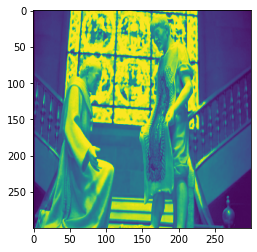

<Figure size 21600x21600 with 0 Axes>

(300, 300) 



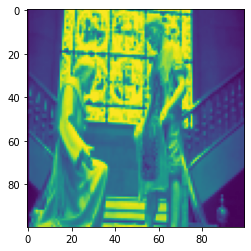

<Figure size 7200x7200 with 0 Axes>

(100, 100)


In [43]:
l = list(train_ds)

img1 = tf.keras.preprocessing.image.array_to_img(l[0][1][0])
plt.imshow(img1)
plt.figure(figsize=(img1.size[0], img1.size[1]))
plt.show()
print(img1.size,"\n")

img2 = tf.keras.preprocessing.image.array_to_img(l[0][0][0])
plt.imshow(img2)
plt.figure(figsize=(img2.size[0], img2.size[1]))
plt.show()
print(img2.size)

In [44]:
loss_function = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
epochs = 100

#Defining the network with Convolutional layers
conv_args = {"activation": "tanh",
             "kernel_initializer": "Orthogonal",
             "padding": "same"}
inputs = keras.Input(shape=(None, None, 1))
x = layers.Conv2D(64, 5, **conv_args)(inputs)
x = layers.Conv2D(32, 3, **conv_args)(x)
x = layers.Conv2D(32, 3, **conv_args)(x)
x = layers.Conv2D(1 * (upscale_factor ** 2), 3, **conv_args)(x)
outputs = tf.nn.depth_to_space(x, upscale_factor)

early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

callbacks = [early_stopping_callback]

#Compiling the model
model = keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=loss_function)

In [9]:
#Training the model
model.fit(train_ds, epochs=epochs, validation_data=valid_ds, verbose=2, callbacks=callbacks)

Epoch 1/100
13/13 - 14s - loss: 0.0599 - val_loss: 0.0273
Epoch 2/100
13/13 - 19s - loss: 0.0209 - val_loss: 0.0143
Epoch 3/100
13/13 - 19s - loss: 0.0128 - val_loss: 0.0103
Epoch 4/100
13/13 - 17s - loss: 0.0102 - val_loss: 0.0081
Epoch 5/100
13/13 - 16s - loss: 0.0083 - val_loss: 0.0071
Epoch 6/100
13/13 - 17s - loss: 0.0072 - val_loss: 0.0063
Epoch 7/100
13/13 - 17s - loss: 0.0064 - val_loss: 0.0057
Epoch 8/100
13/13 - 20s - loss: 0.0059 - val_loss: 0.0052
Epoch 9/100
13/13 - 19s - loss: 0.0055 - val_loss: 0.0049
Epoch 10/100
13/13 - 19s - loss: 0.0052 - val_loss: 0.0048
Epoch 11/100
13/13 - 19s - loss: 0.0051 - val_loss: 0.0045
Epoch 12/100
13/13 - 18s - loss: 0.0050 - val_loss: 0.0044
Epoch 13/100
13/13 - 17s - loss: 0.0047 - val_loss: 0.0048
Epoch 14/100
13/13 - 17s - loss: 0.0050 - val_loss: 0.0042
Epoch 15/100
13/13 - 17s - loss: 0.0048 - val_loss: 0.0047
Epoch 16/100
13/13 - 18s - loss: 0.0046 - val_loss: 0.0041
Epoch 17/100
13/13 - 18s - loss: 0.0043 - val_loss: 0.0040
Epoch 

In [11]:
model.save('FSRCNN.keras')

PSNR of low resolution image and high resolution image is 30.3819
PSNR of predict and high resolution is 5.1069


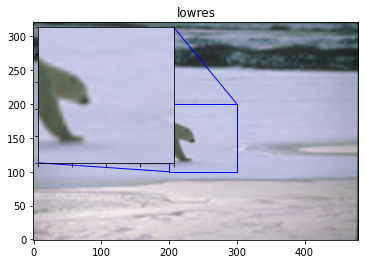

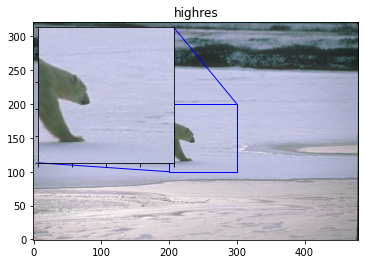

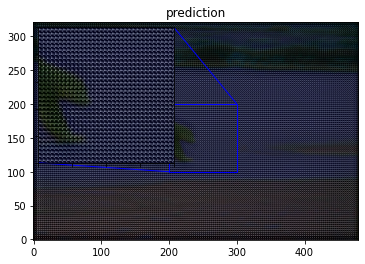

PSNR of low resolution image and high resolution image is 22.9969
PSNR of predict and high resolution is 7.4283


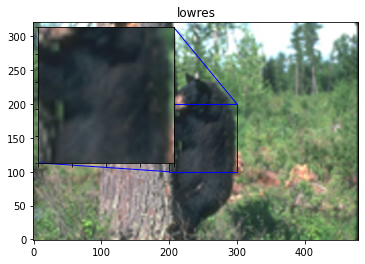

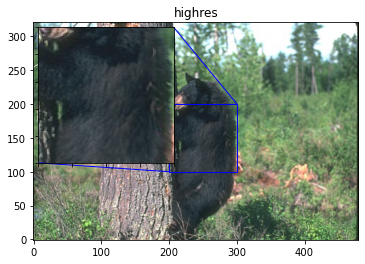

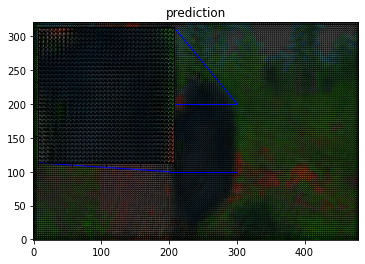

PSNR of low resolution image and high resolution image is 33.7648
PSNR of predict and high resolution is 8.5701


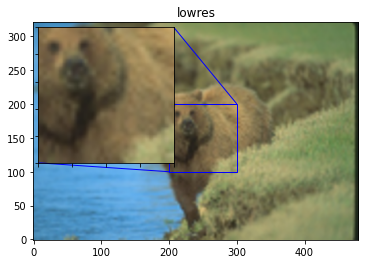

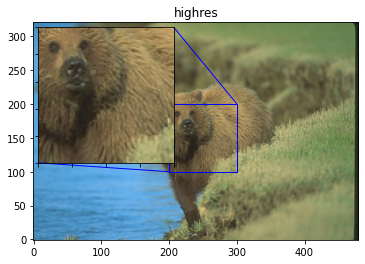

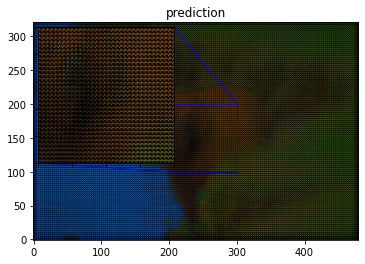

PSNR of low resolution image and high resolution image is 27.7062
PSNR of predict and high resolution is 6.7573


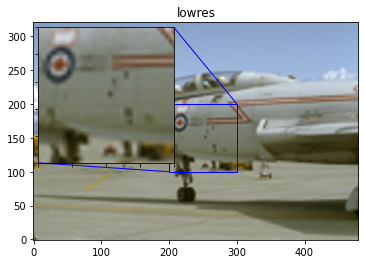

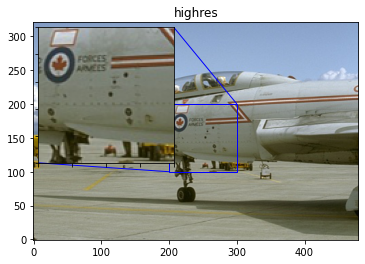

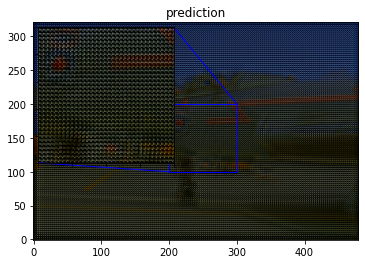

PSNR of low resolution image and high resolution image is 22.7002
PSNR of predict and high resolution is 10.2257


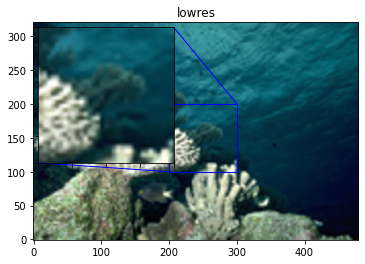

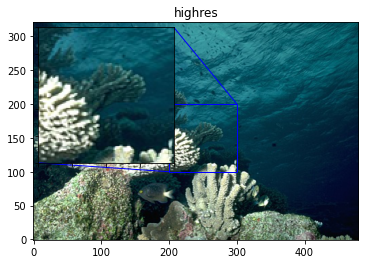

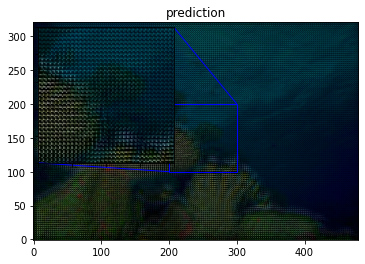

PSNR of low resolution image and high resolution image is 22.2816
PSNR of predict and high resolution is 9.2786


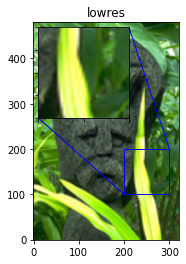

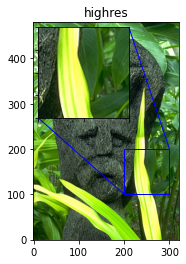

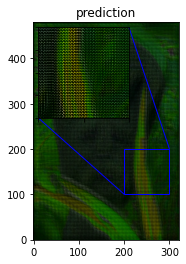

PSNR of low resolution image and high resolution image is 21.2786
PSNR of predict and high resolution is 8.9225


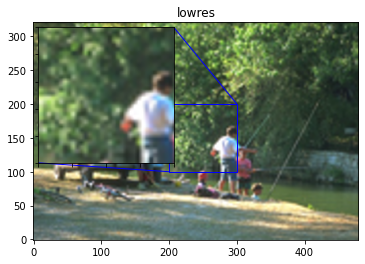

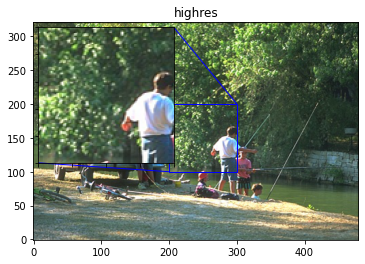

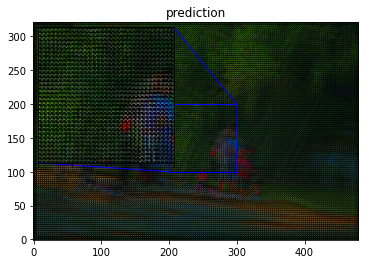

PSNR of low resolution image and high resolution image is 23.6220
PSNR of predict and high resolution is 6.9117


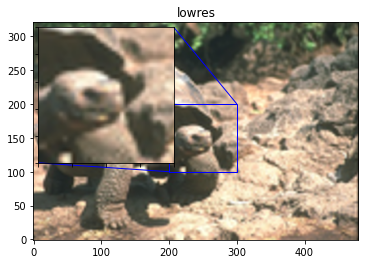

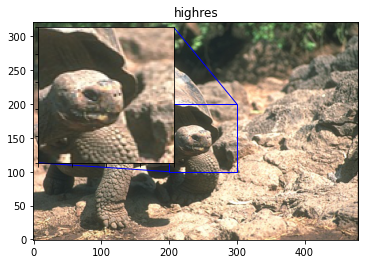

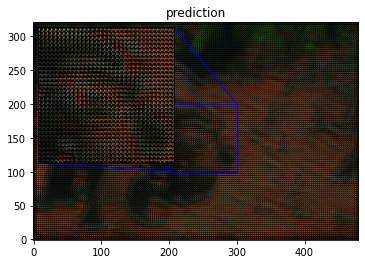

PSNR of low resolution image and high resolution image is 33.4889
PSNR of predict and high resolution is 12.3029


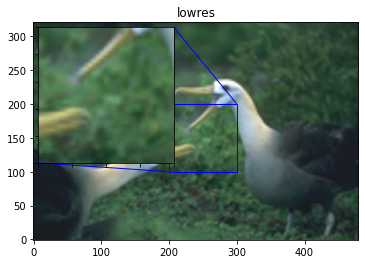

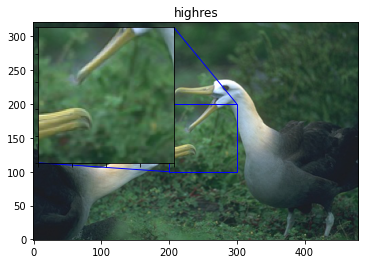

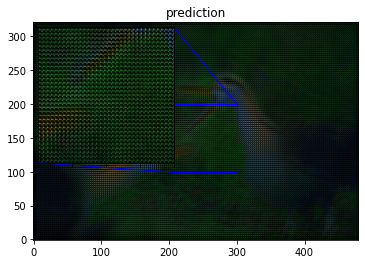

PSNR of low resolution image and high resolution image is 26.3507
PSNR of predict and high resolution is 7.4322


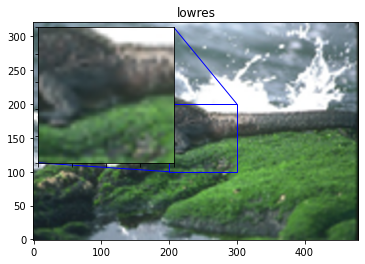

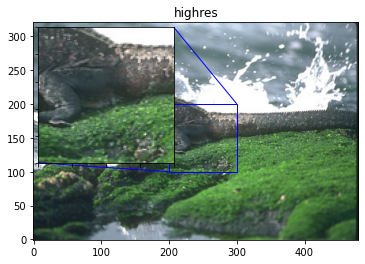

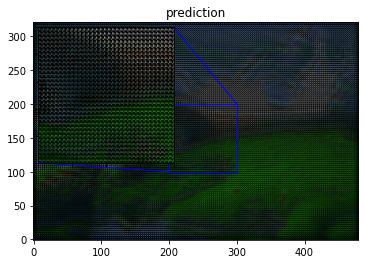

Avg. PSNR of lowres images is 26.4572
Avg. PSNR of reconstructions is 8.2936


In [56]:
import cv2
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize((img.size[0] // upscale_factor, img.size[1] // upscale_factor),PIL.Image.BICUBIC)

def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert("RGB")
    return out_img

def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    file_out = os.path.join(dataset_path, "images_out", str(prefix) + "-" + title + ".png")
    plt.savefig(file_out)
    plt.show()

counter = 0
for index, test_img_path in enumerate(test_imgs[0:10]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print("PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr)
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")
    counter+=1

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))